In [3]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer
import umap

from grnndata import GRNAnnData, read_h5ad
from grnndata import utils 

import bengrn as ben

from scipy import stats
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns
import hdbscan

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

In [4]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/cmgiqxw/epoch=3-step=20000.ckpt', precpt_gene_emb = '../../data/temp/embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


In [ ]:
print(model)

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 128)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 128)
  )
  (depth_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (norm_and_dropout): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Dropout(p=0.1, inplace=False)
  )


In [5]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI
# and yBCKp6HmXuHa0cZptMo7

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [ ]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

In [ ]:
adata

AnnData object with n_obs × n_vars = 12590 × 70116
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'leiden

In [ ]:
sc.pl.umap(adata, color=["cell_type", "development_stage", "assay", "disease", "sex", "self_reported_ethnicity"], wspace=0.7)


In [1]:
adata.obs.cell_type.value_counts()

NameError: name 'adata' is not defined

In [6]:
grn_inferer = GRNfer(model, adata, how="random expr")

INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-03-25 20:00:09,258:INFO - Using 16bit Automatic Mixed Precision (AMP)
2024-03-25 20:00:09,258:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-03-25 20:00:09,308:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-03-25 20:00:09,311:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-03-25 20:00:09,313:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-25 20:00:09,316:INFO - HPU available: False, using: 0 HPUs


In [7]:
grn_inferer.model.get_attention_layer = [3]
grn_inferer.predict(cell_type="oligodendrocyte precursor cell")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-03-25 20:00:12,728:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/loops/prediction_loop.py:234: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")


In [8]:
grn_inferer.preprocess = "softmax"
grn_inferer.doplot = True

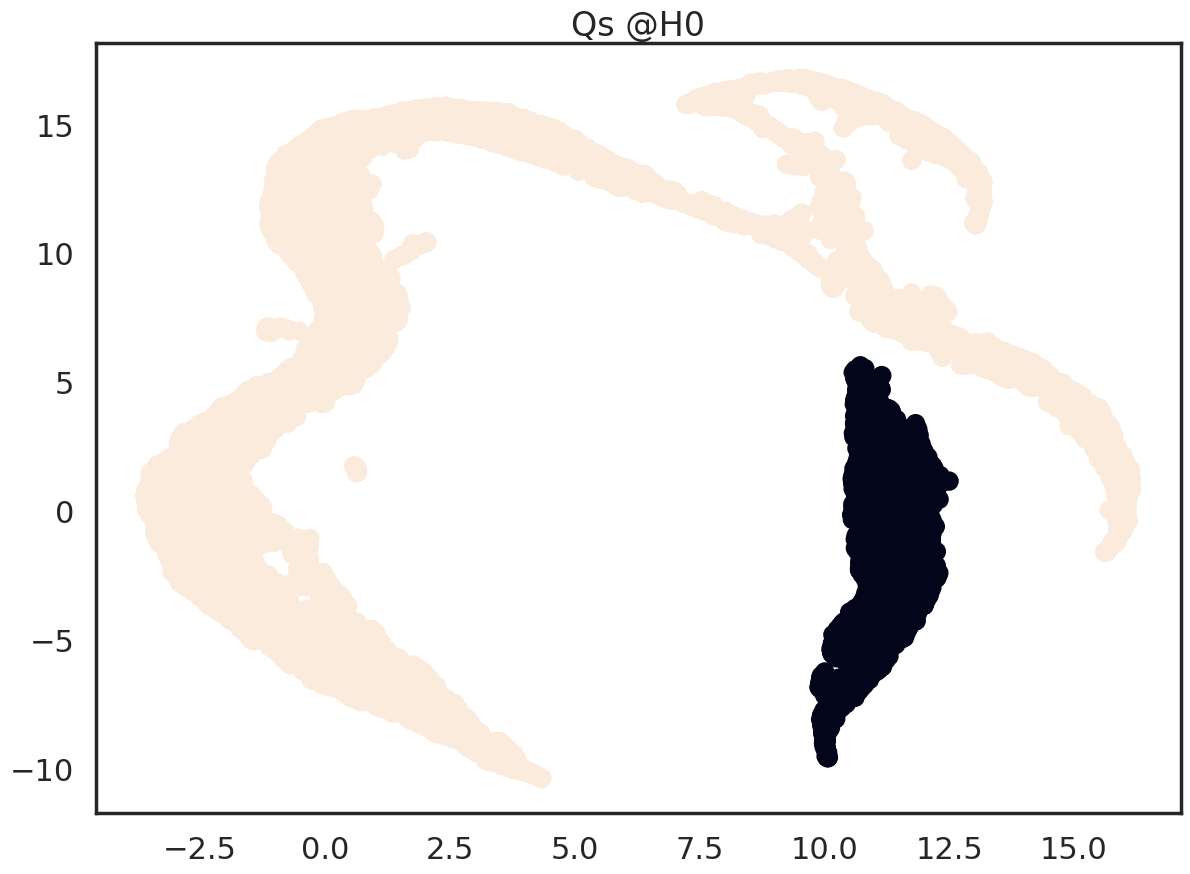

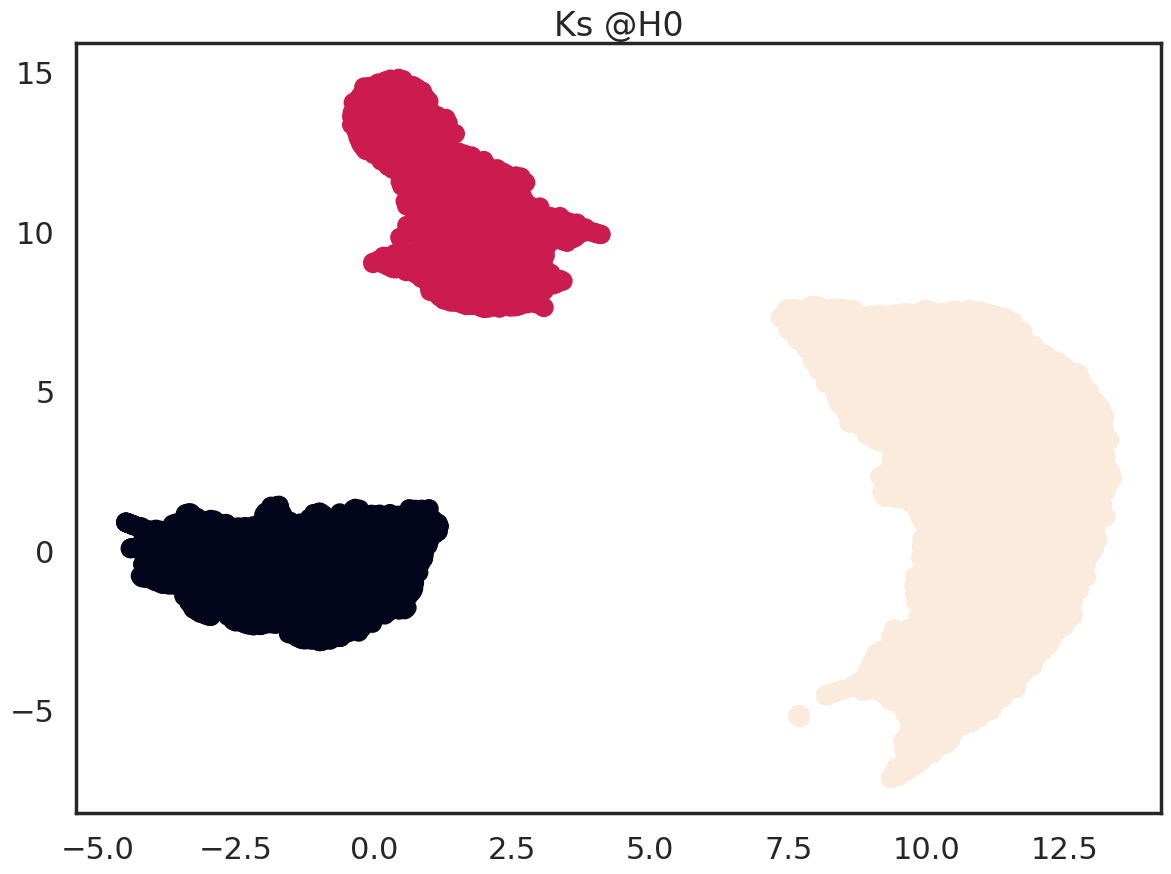

In [9]:
adj = grn_inferer.aggregate(grn_inferer.model.mean_attn[0])

In [ ]:
adj

In [5]:
attn = grn_inferer(cell_type="oligodendrocyte precursor cell", layers=[3])

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [7]:
grn_inferer.model.mean_attn[0].shape

torch.Size([64, 2008, 2, 4, 32])

## Test a bunch of random and see what make them similar

In [15]:
from scprint.tasks.grn import get_GTdb

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [19]:
gt = get_GTdb()

In [10]:
from scdataloader.utils import load_genes

In [22]:
genedf = load_genes()

In [23]:
rn = {j['symbol']:i for i,j in genedf[['symbol']].iterrows() if j['symbol'] is not None}

In [24]:
rn

{'TSPAN6': 'ENSG00000000003',
 'TNMD': 'ENSG00000000005',
 'DPM1': 'ENSG00000000419',
 'SCYL3': 'ENSG00000000457',
 'C1orf112': 'ENSG00000000460',
 'FGR': 'ENSG00000000938',
 'CFH': 'ENSG00000000971',
 'FUCA2': 'ENSG00000001036',
 'GCLC': 'ENSG00000001084',
 'NFYA': 'ENSG00000001167',
 'STPG1': 'ENSG00000001460',
 'NIPAL3': 'ENSG00000001461',
 'LAS1L': 'ENSG00000001497',
 'ENPP4': 'ENSG00000001561',
 'SEMA3F': 'ENSG00000001617',
 'CFTR': 'ENSG00000001626',
 'ANKIB1': 'ENSG00000001629',
 'CYP51A1': 'ENSG00000001630',
 'KRIT1': 'ENSG00000001631',
 'RAD52': 'ENSG00000002016',
 'MYH16': 'ENSG00000002079',
 'BAD': 'ENSG00000002330',
 'LAP3': 'ENSG00000002549',
 'CD99': 'ENSG00000292348',
 'HS3ST1': 'ENSG00000002587',
 'AOC1': 'ENSG00000002726',
 'WNT16': 'ENSG00000002745',
 'HECW1': 'ENSG00000002746',
 'MAD1L1': 'ENSG00000002822',
 'LASP1': 'ENSG00000002834',
 'SNX11': 'ENSG00000002919',
 'TMEM176A': 'ENSG00000002933',
 'M6PR': 'ENSG00000003056',
 'KLHL13': 'ENSG00000003096',
 'CYP26B1': 'E

In [29]:
(set(gt.source))

8896

In [27]:
gt.iloc[:100].source.replace(rn)

0     ENSG00000198668
1     ENSG00000160014
2     ENSG00000143933
3     ENSG00000105974
4     ENSG00000149295
           ...       
95    ENSG00000133116
96    ENSG00000103769
97    ENSG00000197747
98    ENSG00000198959
99    ENSG00000055732
Name: source, Length: 100, dtype: object

In [25]:
gt = gt.replace({'source': rn, 'target': rn})
# gt = gt[gt.source.isin(rn.values()) & gt.target.isin(rn.values())]

KeyboardInterrupt: 

In [13]:
gt

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,type,n_sources,n_primary_sources,n_references,references_stripped
0,CALM1,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
1,CALM3,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
2,CALM2,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
3,CAV1,TRPC1,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,post_translational,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,DRD2,TRPC1,True,True,False,True,True,False,1,TRIP:18261457,TRIP,post_translational,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278574,TAF7,MIMAT0000075,True,False,False,False,False,False,0,NaN,ENCODE_tf-mirna,mirna_transcriptional,1,0,None,None
278575,RAD21,MIMAT0005867,True,False,False,False,False,False,0,NaN,ENCODE_tf-mirna,mirna_transcriptional,1,0,None,None
278576,P23511,MIMAT0003308,True,False,False,False,False,False,0,NaN,ENCODE_tf-mirna,mirna_transcriptional,1,0,None,None
278577,FOSL2,MIMAT0005867,True,False,False,False,False,False,0,NaN,ENCODE_tf-mirna,mirna_transcriptional,1,0,None,None


In [6]:
used = []
for i, attn in enumerate(grn_inferer.model.mean_attn[0]):
    attn = attn[:, 0, :, :].permute(1, 0, 2) @ attn[:, 1, :, :].permute(1, 2, 0)
    attn = torch.softmax(attn,-1).max(0)[0].sum(0).detach().cpu().numpy()
    genes = np.argsort(-attn)[:10] - 8
    print(genes)
    genes = genes[genes>0]
    names = np.array(grn_inferer.model.genes)[grn_inferer.model.pos[i].detach().cpu().numpy()]
    print(names[genes])
    used.append(set(names[genes]))
    print(attn[np.argsort(-attn)[:10]]) # 10 genes explain 72/80 of the attention
#    break
print(Counter([a for i in used for a in i]))

[  -4  670  242  789 1500 1072  626   -2  985 1073]
['ENSG00000186468' 'ENSG00000133030' 'ENSG00000105640' 'ENSG00000169783'
 'ENSG00000157637' 'ENSG00000165072' 'ENSG00000142676' 'ENSG00000165219']
[2004.   1888.   1186.   1010.    624.    354.8   213.8    89.94   38.34
   37.97]
[  -4  799  379   -2  927  753 1617 1917 1130 1944]


['ENSG00000167526' 'ENSG00000181481' 'ENSG00000198034' 'ENSG00000198947'
 'ENSG00000140443' 'ENSG00000134871' 'ENSG00000075624' 'ENSG00000288375']
[1981.   1791.   1785.   1015.    366.    269.5   201.    145.9   105.44
   89.  ]
[  -4  220    4 1983 1257 1516 1139 1649 1052  394]

[1981.   1791.   1785.   1015.    366.    269.5   201.    145.9   105.44
   89.  ]
[  -4  220    4 1983 1257 1516 1139 1649 1052  394]
['ENSG00000142937' 'ENSG00000006740' 'ENSG00000164587' 'ENSG00000160219'
 'ENSG00000277334' 'ENSG00000075624' 'ENSG00000276353' 'ENSG00000144713'
 'ENSG00000184986']
[1992.  1393.  1361.  1321.   589.5  268.8  268.   193.6  136.6   97.5]
[  -4   14 1671 1945  213 1475 1971 1838 1895 1314]
['ENSG00000167526' 'ENSG00000136444' 'ENSG00000111245' 'ENSG00000123066'
 'ENSG00000172292' 'ENSG00000237445' 'ENSG00000251771' 'ENSG00000276971'
 'ENSG00000205542']
[1942.   1759.   1755.   1115.    392.8   204.4   155.6   137.9   136.1
   80.25]
[  -4 1097   -2 1771  290  169  791 1899 144

## create the aggregation on random

In [59]:
mean_attn = torch.zeros([len(model.genes)+len(model.labels)+2]+ list(grn_inferer.model.mean_attn[0].shape[2:]))
div = torch.zeros([len(model.genes)+len(model.labels)+2]+ list(grn_inferer.model.mean_attn[0].shape[2:]))

for i in range(grn_inferer.model.mean_attn[0].shape[0]):
    loc = torch.cat([torch.Tensor([r for r in range(8)]), grn_inferer.model.pos[i]]).int()
    mean_attn[loc, :,:,:] += grn_inferer.model.mean_attn[0][i].detach().to("cpu")
    div[loc,:,:,:] +=1
mean_attn = mean_attn / div
goodloc = div.sum((1,2,3))>0
mean_attn = mean_attn[goodloc]

In [20]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})


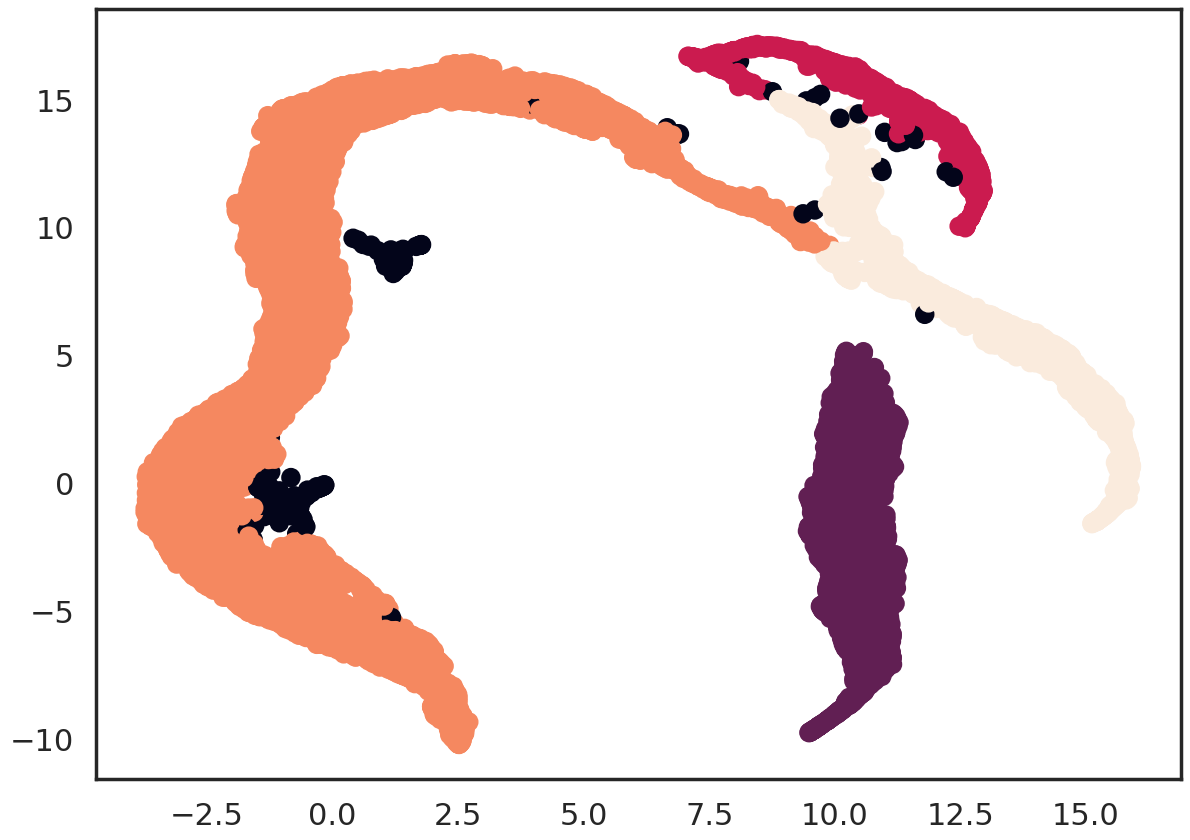

In [83]:
fit = umap.UMAP()
mm = fit.fit_transform(mean_attn[0:][:, 0, 0, :])
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(mm)
plt.scatter(mm[:,0], mm[:,1], c=labels)

In [76]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(mm)

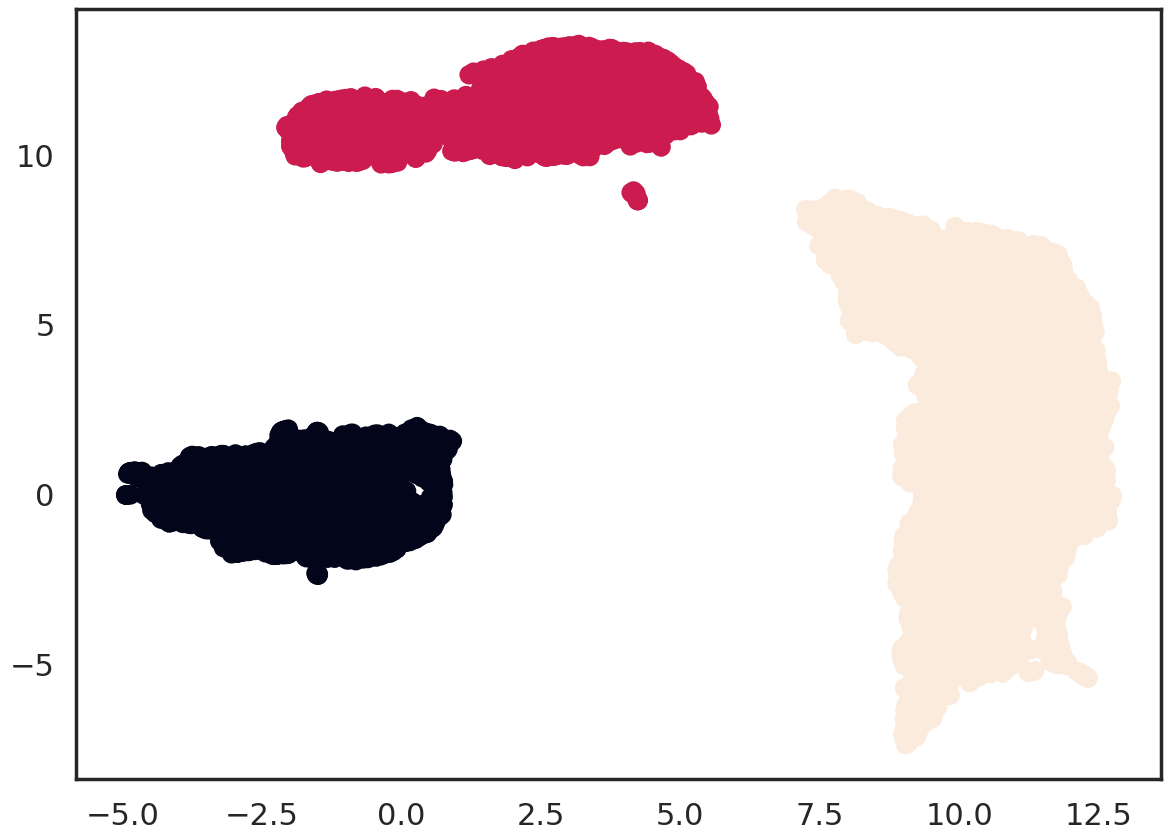

In [77]:
plt.scatter(mm[:,0], mm[:,1], c=labels)

In [81]:
names[labels[8:]==1]
# what makes them cluster??

array(['ENSG00000000971', 'ENSG00000001617', 'ENSG00000002919', ...,
       'ENSG00000292346', 'ENSG00000292348', 'ENSG00000292354'],
      dtype='<U15')

In [66]:
attn = mean_attn[0:][:, 0, :, :].permute(
    1, 0, 2
) @ mean_attn[0:][:, 1, :, :].permute(1, 2, 0)

In [67]:
attn.shape

torch.Size([4, 19460, 19460])

In [68]:
res = torch.softmax(attn,-1).max(0)[0].sum(0)
res.sum(), res.shape, np.argsort(-res)[:10] - 8, res[np.argsort(-res)[:10]] # 10 genes explain 72/80 of the attention

(tensor(77836.7656),
 torch.Size([19460]),
 tensor([ 6578,    -4,  7724, 11617,  6834,  2978, 17034, 17018, 15408, 14741]),
 tensor([11292.3105, 11248.6855,  9443.1543,  6045.7104,  5992.7031,  5870.1182,
          4494.3237,  3719.2683,  2825.2148,  1573.9918]))

In [72]:
genes

tensor([ 6578,  7724, 11617,  6834,  2978, 17034, 17018, 15408, 14741])

In [71]:
genes = np.argsort(-res)[:10] - 8
genes = genes[genes>0]
names = np.array(grn_inferer.model.genes)[goodloc[8:]]
names[genes]


array(['ENSG00000142871', 'ENSG00000154188', 'ENSG00000183722',
       'ENSG00000144659', 'ENSG00000109424', 'ENSG00000265215',
       'ENSG00000265048', 'ENSG00000236457', 'ENSG00000223608'],
      dtype='<U15')

In [1]:
a

NameError: name 'a' is not defined

<Axes: >

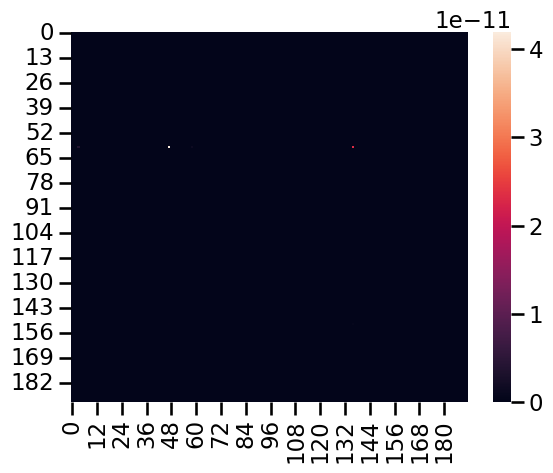

In [16]:
attn_numpy = torch.softmax(attn,-1)[0,8:200,8:200].detach().cpu().numpy()
#attn_numpy = attn[0,:200,:200]

# Create a heatmap
sns.heatmap(attn_numpy)

## debug the masker and downsampler

In [9]:
from scprint.model.utils import downsample_profile, masker
from scdataloader.data import SimpleAnnDataset
from scdataloader import Collator
from grnndata import utils
from torch.utils.data import DataLoader
adataset = SimpleAnnDataset(
    adata, obs_to_output=["organism_ontology_term_id"]
)
col = Collator(
    organisms=['NCBITaxon:9606'],
    valid_genes=model.genes,
    how="random expr",
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=64,
    num_workers=1,
    shuffle=False,
)


In [11]:
for i in dataloader:
    break


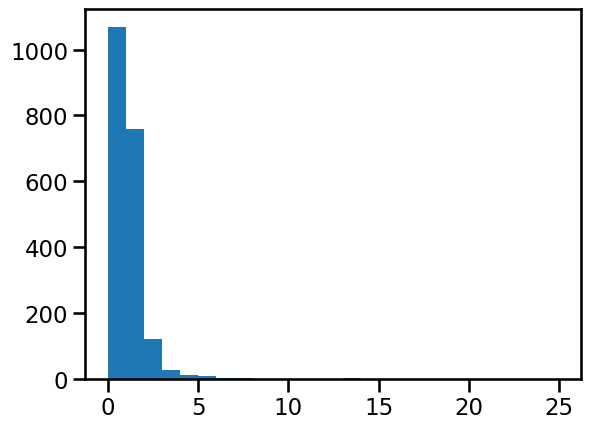

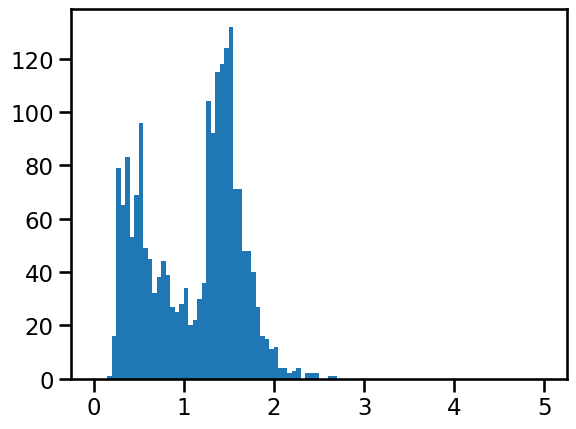

In [ ]:
import matplotlib.pyplot as plt

plt.hist(i["x"][0], bins=25, range=(0,25))
plt.show()
plt.hist(i["x"].mean(0), bins=100, range=(0,5))
plt.show()


In [20]:
x  = downsample_profile(i["x"], 0.4)

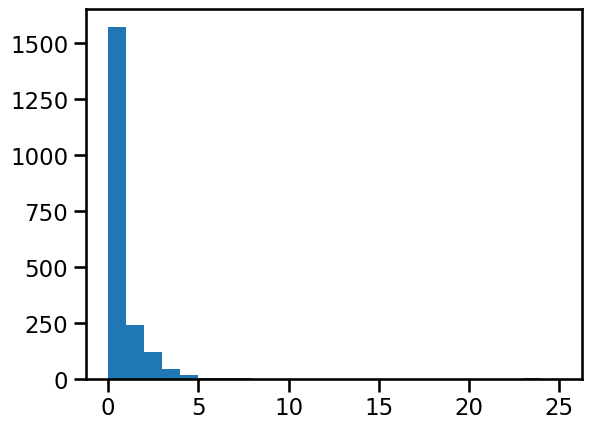

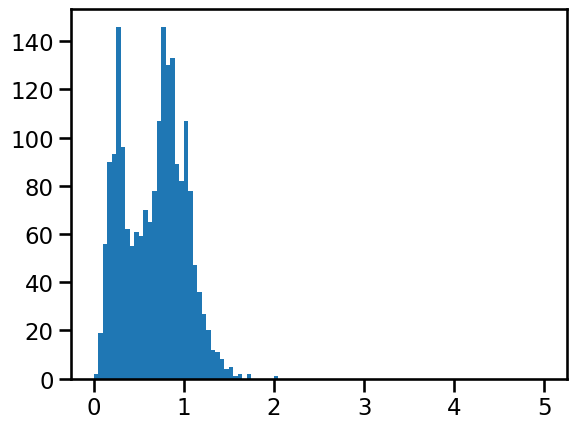

In [95]:
import matplotlib.pyplot as plt

plt.hist(x[0], bins=25, range=(0,25))
plt.show()
plt.hist(x.to(float).mean(0), bins=100, range=(0,5))
plt.show()


## Test a bunch of Cells and see if similar attention